In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from skimage.feature import hog
from graphviz import Digraph
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from PIL import Image

In [ ]:
!curl -o mango_leaf_bd_dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103M  100  103M    0     0  67.3M      0  0:00:01  0:00:01 --:--:-- 67.3M


In [ ]:
!unzip /content/mango_leaf_bd_dataset.zip

Archive:  /content/mango_leaf_bd_dataset.zip
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124334 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnos

In [ ]:
!mv MangoLeafBD\ Dataset mangoLeafBDDataset

In [ ]:
data_dir = '/content/mangoLeafBDDataset'

# Get the list of classes (folders)
classes = os.listdir(data_dir)

# Prepare lists to store image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        # Append image path and class label to lists
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few rows to inspect
print("Sample rows from the dataset:")
print(df.head())

# Check the distribution of classes
print("\nClass distribution:")
print(df['label'].value_counts())

Sample rows from the dataset:
                                          image_path        label
0  /content/mangoLeafBDDataset/Sooty Mould/IMG_20...  Sooty Mould
1  /content/mangoLeafBDDataset/Sooty Mould/IMG_20...  Sooty Mould
2  /content/mangoLeafBDDataset/Sooty Mould/IMG_20...  Sooty Mould
3  /content/mangoLeafBDDataset/Sooty Mould/IMG_20...  Sooty Mould
4  /content/mangoLeafBDDataset/Sooty Mould/IMG_20...  Sooty Mould

Class distribution:
label
Sooty Mould         500
Healthy             500
Gall Midge          500
Bacterial Canker    500
Powdery Mildew      500
Die Back            500
Anthracnose         500
Cutting Weevil      500
Name: count, dtype: int64


In [ ]:
image_shapes = []
for category in classes: # Changed 'categories' to 'classes'
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            image_shapes.append(img.size)

unique_shapes = np.unique(image_shapes, axis=0)
print("Unique image dimensions:", unique_shapes)

Unique image dimensions: [[187 320]
 [189 320]
 [210 320]
 [213 320]
 [214 320]
 [217 320]
 [218 320]
 [219 320]
 [224 320]
 [226 320]
 [229 320]
 [234 320]
 [237 320]
 [238 320]
 [240 240]
 [240 245]
 [240 246]
 [240 262]
 [240 263]
 [240 265]
 [240 271]
 [240 272]
 [240 273]
 [240 282]
 [240 283]
 [240 285]
 [240 290]
 [240 297]
 [240 299]
 [240 306]
 [240 308]
 [240 317]
 [240 320]
 [244 240]
 [249 240]
 [262 240]
 [266 240]
 [282 240]
 [284 240]
 [288 240]
 [292 240]
 [297 240]
 [300 240]
 [302 240]
 [304 240]
 [305 240]
 [307 240]
 [309 240]
 [313 240]
 [314 240]
 [320  70]
 [320  86]
 [320  92]
 [320 160]
 [320 162]
 [320 166]
 [320 171]
 [320 173]
 [320 175]
 [320 179]
 [320 182]
 [320 193]
 [320 195]
 [320 197]
 [320 199]
 [320 200]
 [320 205]
 [320 206]
 [320 207]
 [320 209]
 [320 210]
 [320 211]
 [320 212]
 [320 213]
 [320 214]
 [320 217]
 [320 218]
 [320 219]
 [320 220]
 [320 221]
 [320 222]
 [320 223]
 [320 224]
 [320 226]
 [320 227]
 [320 228]
 [320 229]
 [320 230]
 [320 2

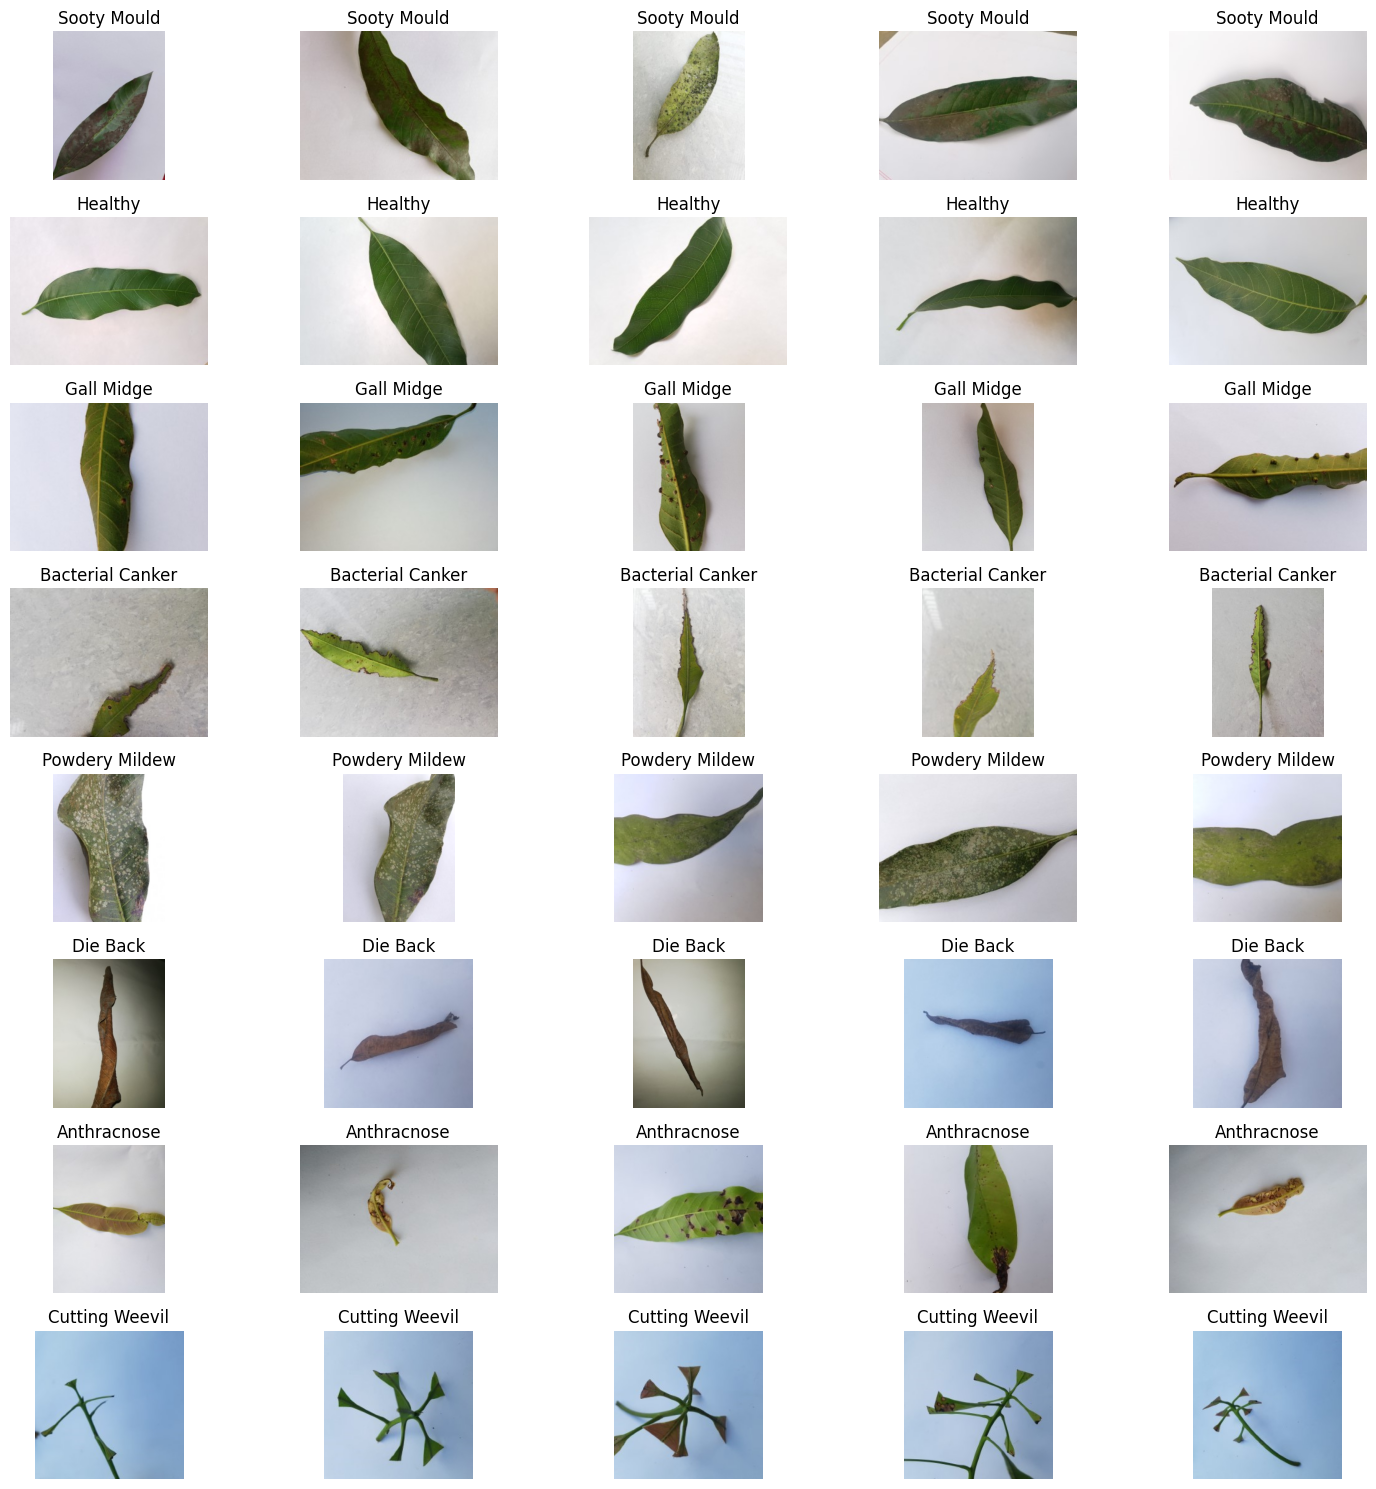

In [ ]:
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 15))
for i, category in enumerate(classes):
    category_path = os.path.join(data_dir, category)
    for j, img_name in enumerate(os.listdir(category_path)[:5]):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

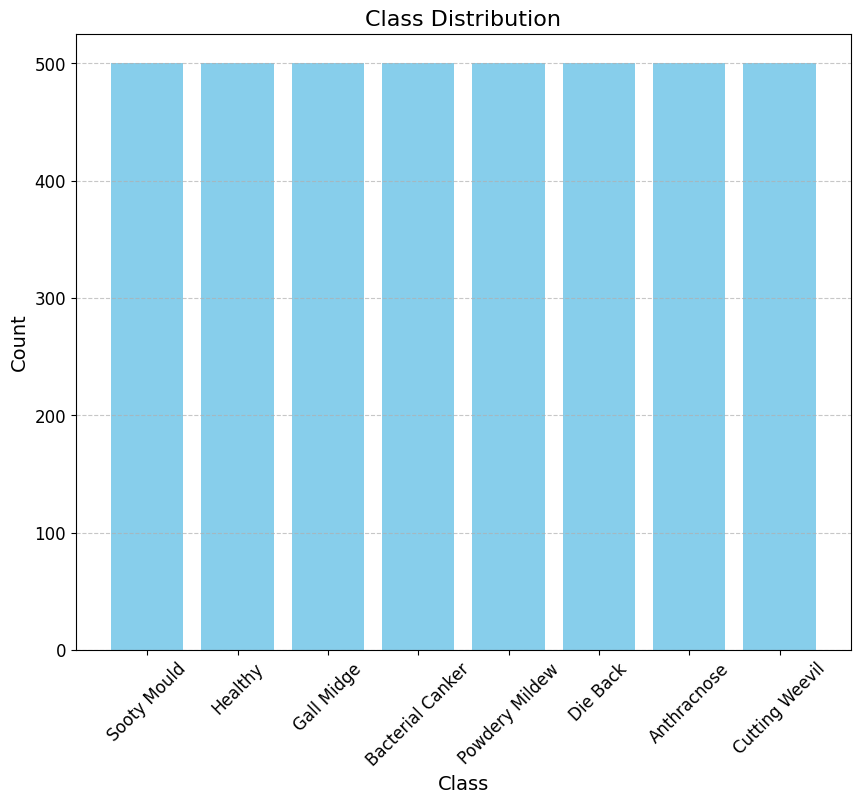

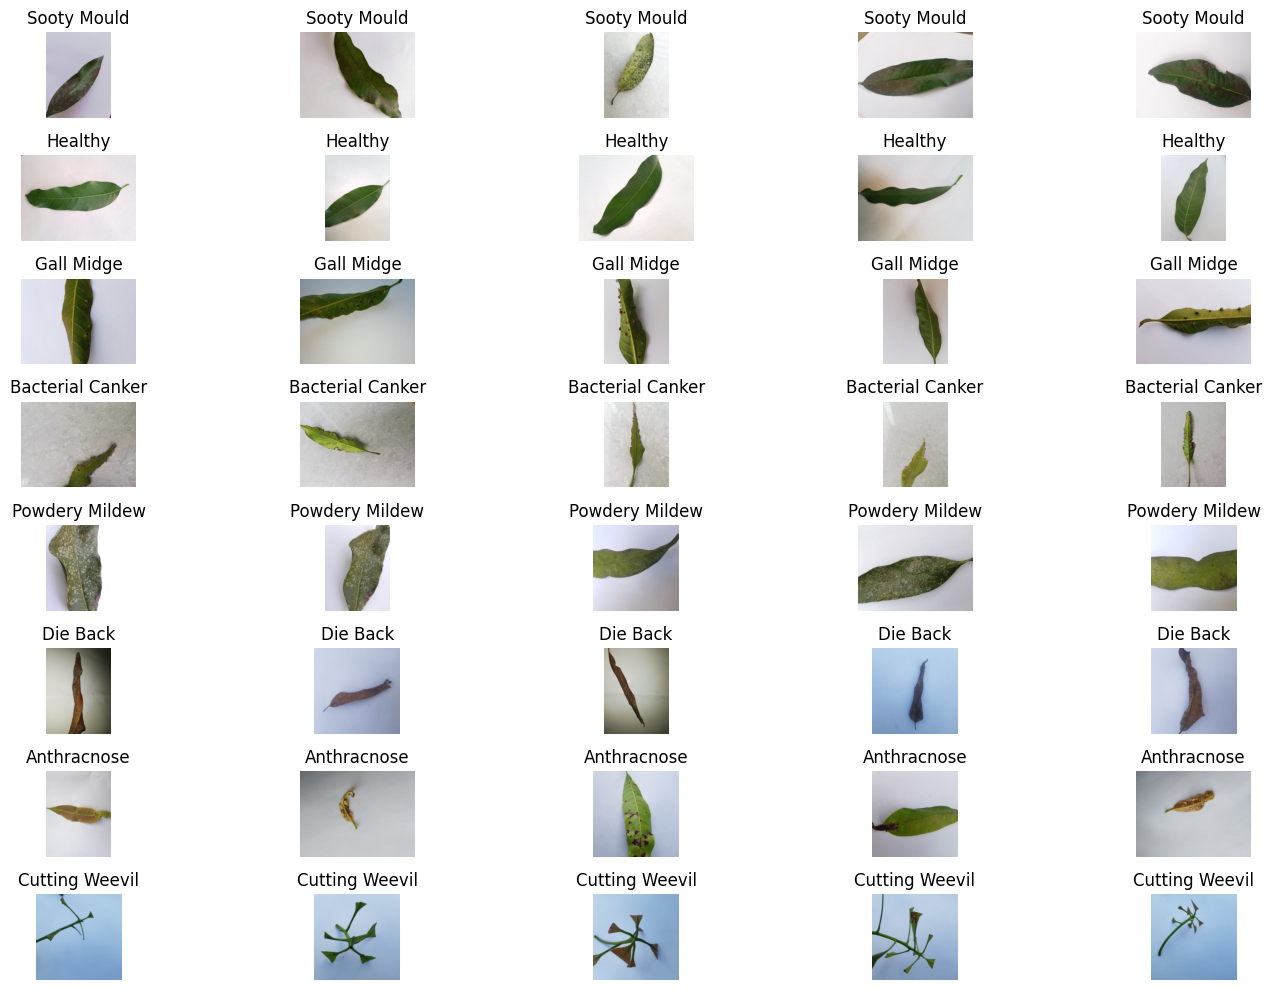

In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])  # Fit the label encoder with the class labels from the DataFrame
encoded_labels = label_encoder.transform(df['label'])
class_counts = pd.Series(encoded_labels).value_counts()
class_names = label_encoder.inverse_transform(class_counts.index)

# Plot class distribution
plt.figure(figsize=(10, 8))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

def display_sample_images(dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):  # Check if the class directory exists
            continue
        img_names = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Assuming data_dir contains the dataset
display_sample_images(data_dir, class_names)


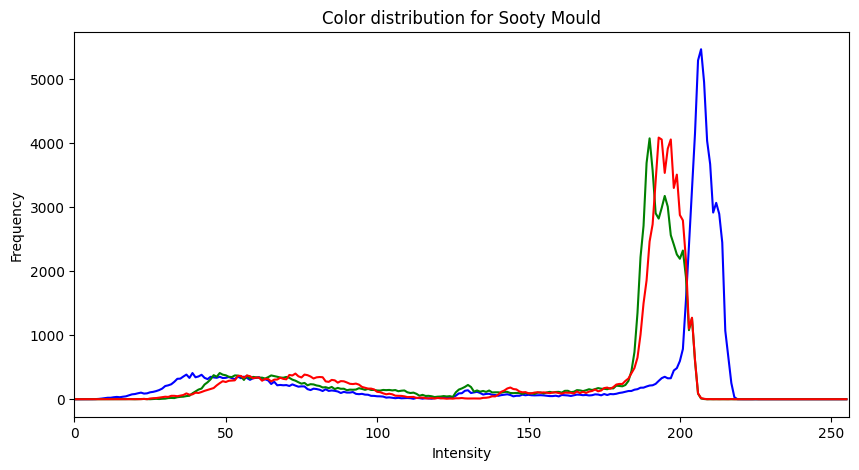

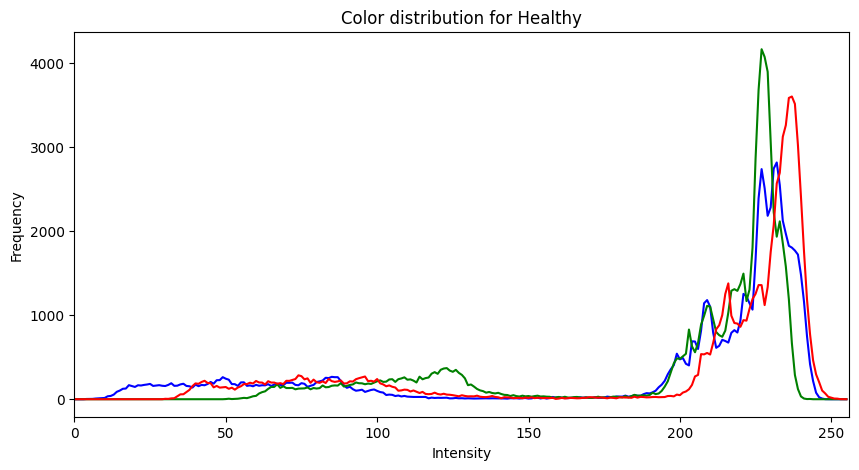

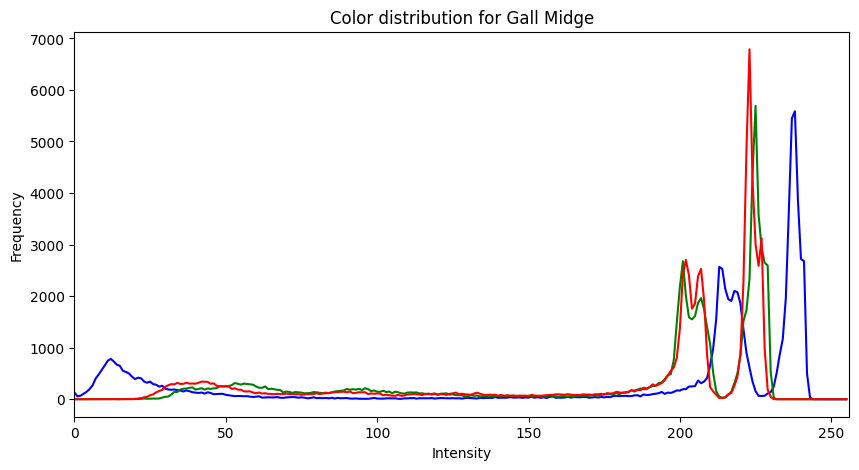

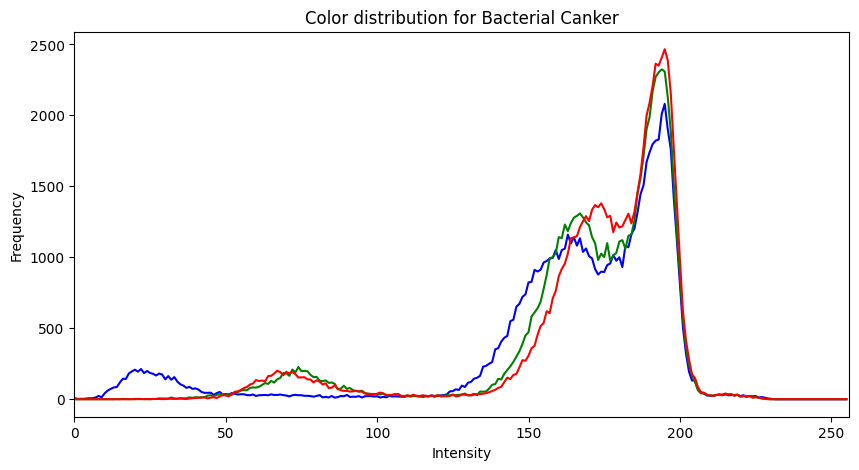

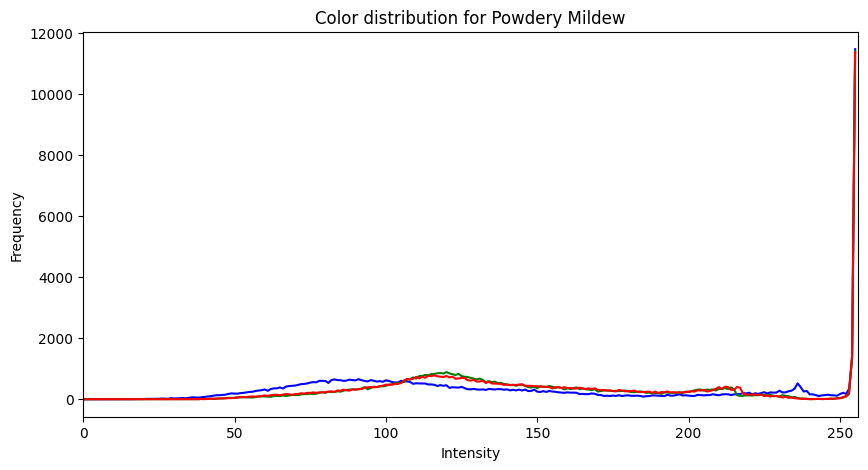

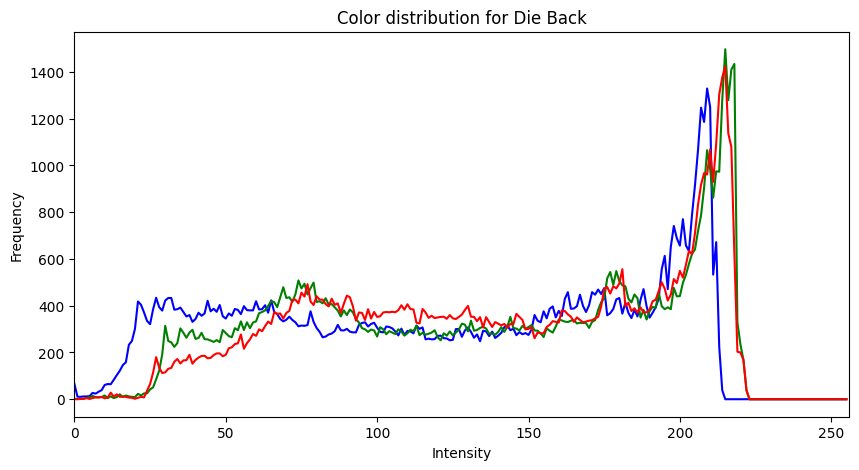

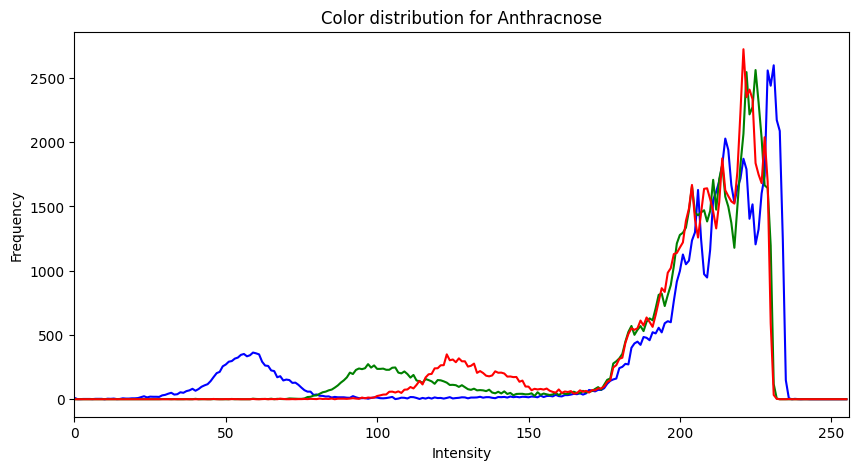

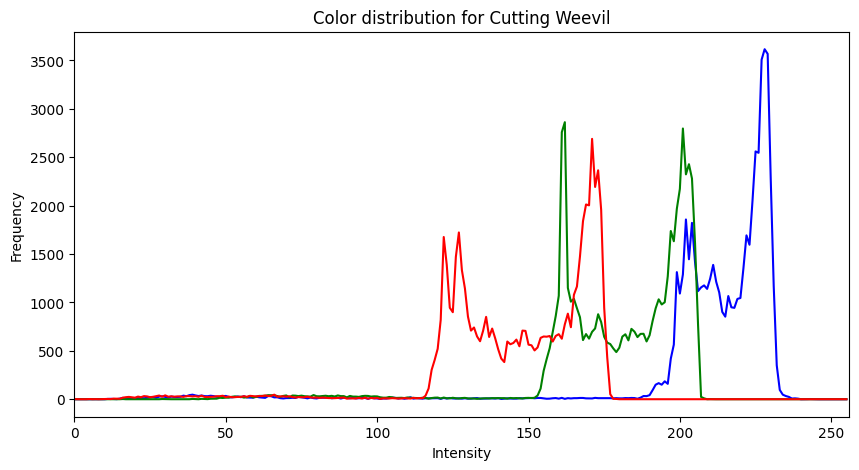

In [ ]:
def calculate_color_histogram(image_path):
    img = cv2.imread(image_path)
    colors = ('b', 'g', 'r')
    hist = {}
    for i, col in enumerate(colors):
        hist[col] = cv2.calcHist([img], [i], None, [256], [0, 256])
    return hist

for category in classes:
    category_path = os.path.join(data_dir, category)
    img_path = os.path.join(category_path, os.listdir(category_path)[0])
    hist = calculate_color_histogram(img_path)
    plt.figure(figsize=(10, 5))
    for col, color_hist in hist.items():
        plt.plot(color_hist, color=col)
        plt.xlim([0, 256])
    plt.title(f"Color distribution for {category}")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.show()

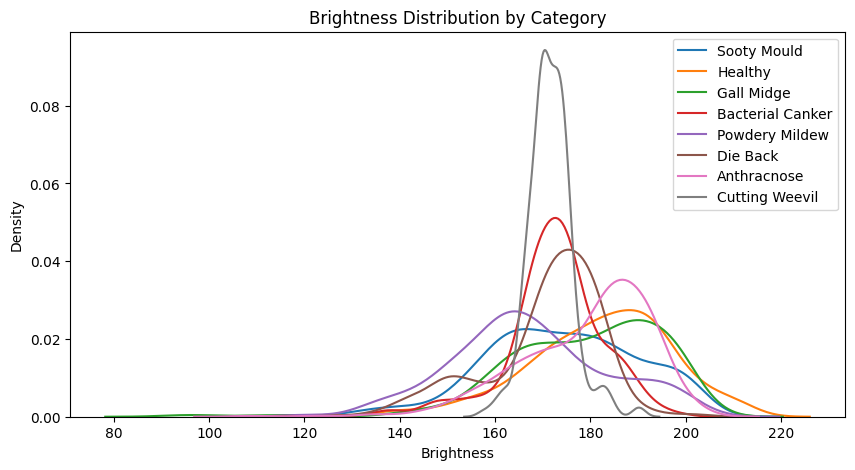

In [ ]:
def calculate_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img)

brightness_values = {}
for category in classes:
    category_path = os.path.join(data_dir, category)
    brightness_values[category] = [calculate_brightness(os.path.join(category_path, img_name)) for img_name in os.listdir(category_path)]
plt.figure(figsize=(10, 5))
for category, values in brightness_values.items():
    sns.kdeplot(values, label=category)
plt.title("Brightness Distribution by Category")
plt.xlabel("Brightness")
plt.legend()
plt.show()

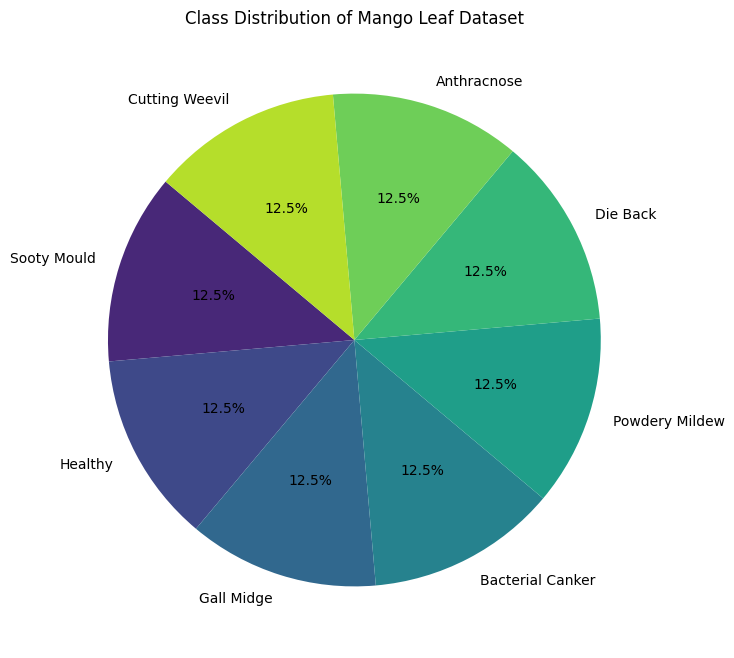

In [ ]:
# Plot the class distribution as a pie chart
plt.figure(figsize=(10, 8))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(classes)))
plt.title("Class Distribution of Mango Leaf Dataset")
plt.ylabel('')
plt.show()

In [ ]:
data_path = '/content/mangoLeafBDDataset'

categories = os.listdir(data_path)

# Parameters
IMG_SIZE = 128  # Resize images to 128x128 pixels

# Initialize lists to store images and labels
data = []
labels = []

# Load images and labels
for category in categories:
    category_path = os.path.join(data_path, category)
    if not os.path.isdir(category_path):
        print(f"Skipping non-folder: {category_path}")
        continue
    print(f"Processing category: {category}")
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        print(f"Reading image: {img_path}")
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.flatten()
            data.append(img)
            labels.append(category)
        else:
            print(f"Failed to load image: {img_path}")

if data:
    data = np.array(data)
    labels = np.array(labels)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
else:
    print("No images were loaded. Please check the dataset path and folder structure.")

Processing category: Sooty Mould
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211212_150324 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211212_143255 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211108_121922 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211211_154416 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211211_154845 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211108_121615 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211211_154103 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211212_144903 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211211_154910 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211108_122336 (Custom).jpg
Reading image: /content/mangoLeafBDDataset/Sooty Mould/IMG_20211108_120832 (Custom).jpg

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (3200, 49152)
Testing data shape: (800, 49152)
Training labels shape: (3200,)
Testing labels shape: (800,)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Model Accuracy: 0.85625

Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.88      0.88      0.88        91
Bacterial Canker       0.89      0.86      0.87       101
  Cutting Weevil       0.97      0.96      0.96        93
        Die Back       0.91      0.94      0.93        90
      Gall Midge       0.80      0.73      0.77       112
         Healthy       0.79      0.92      0.85        86
  Powdery Mildew       0.85      0.80      0.82       104
     Sooty Mould       0.79      0.81      0.80       123

        accuracy                           0.86       800
       macro avg       0.86      0.86      0.86       800
    weighted avg       0.86      0.86      0.86       800



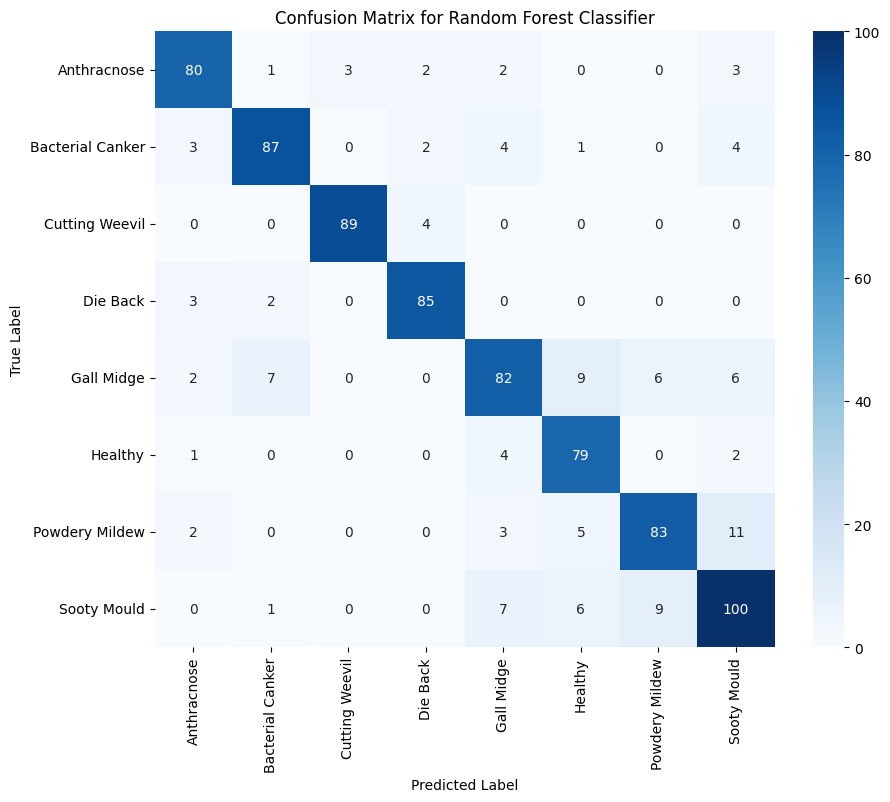

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

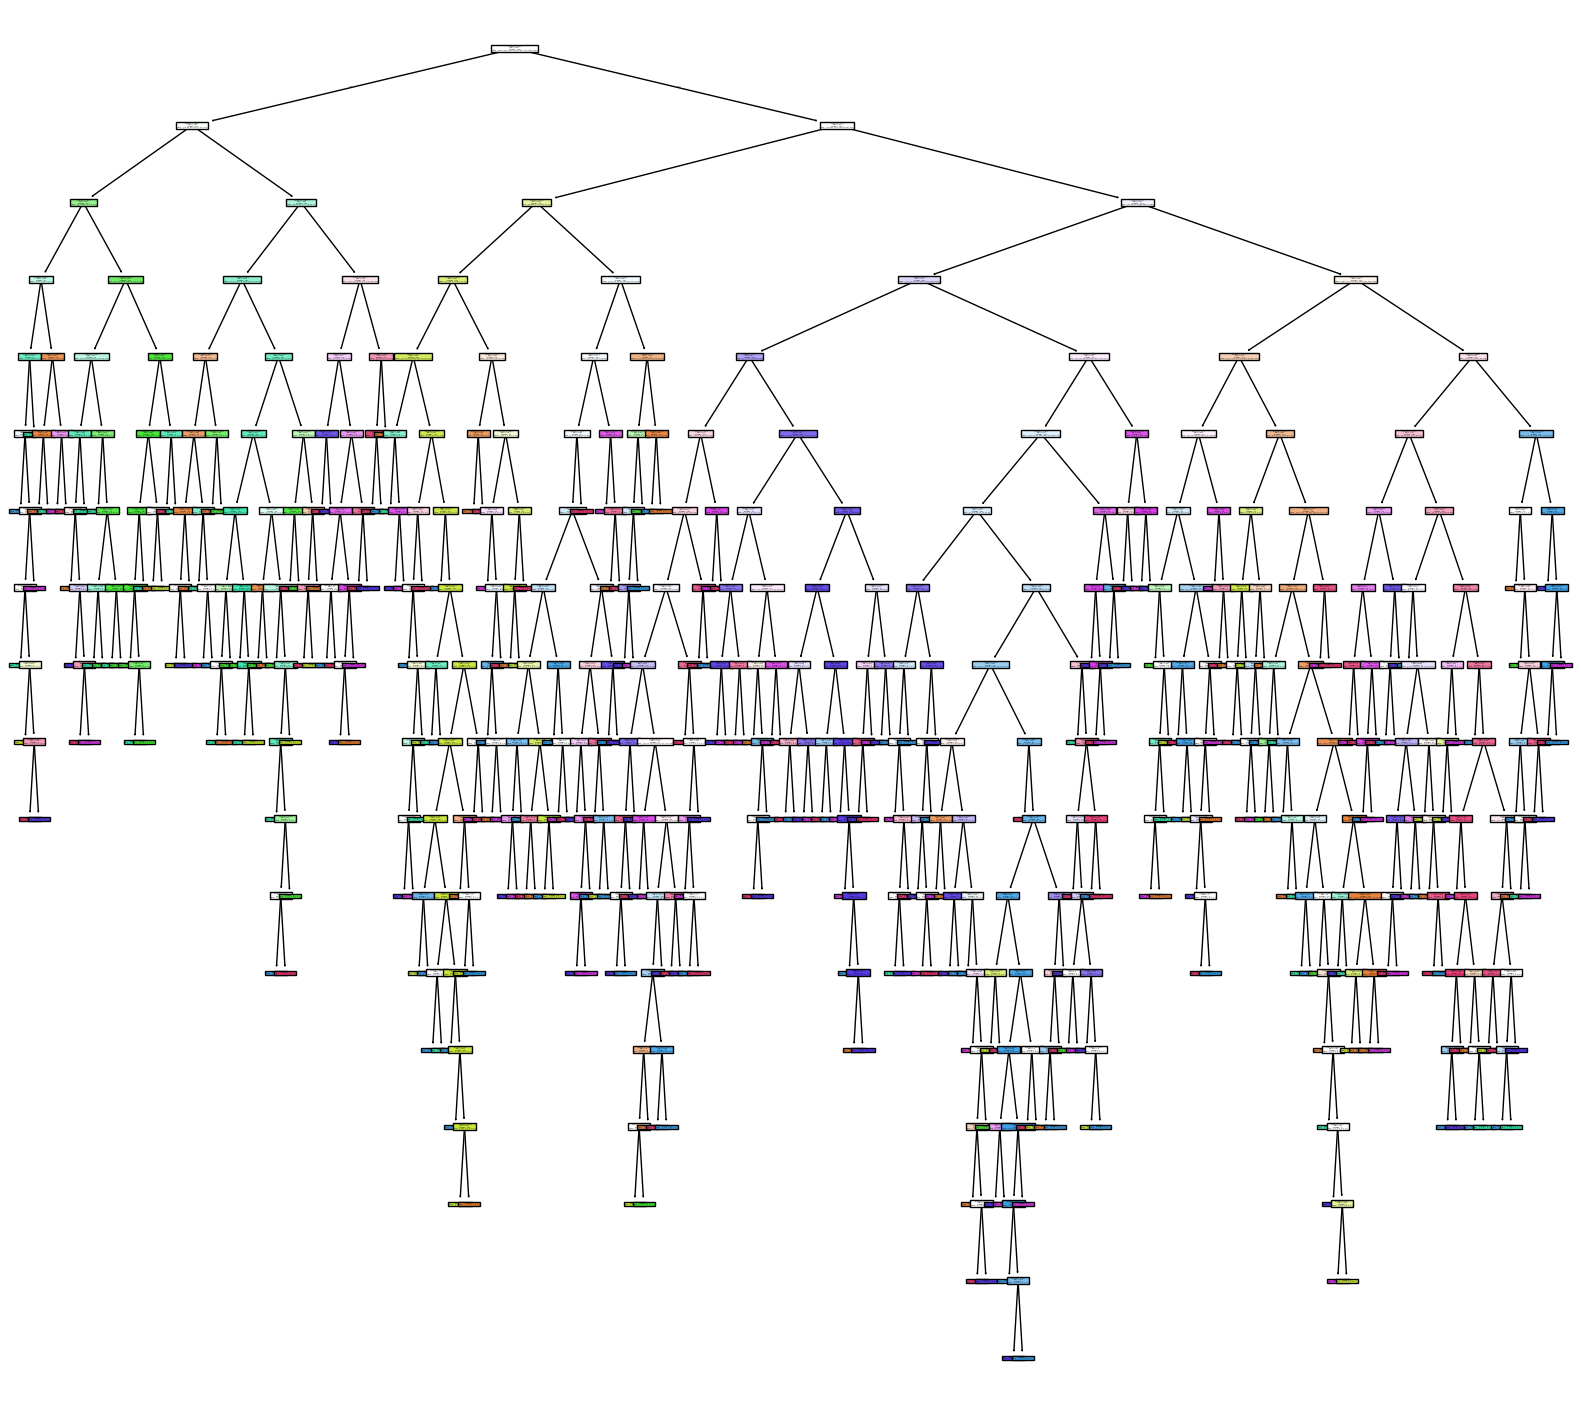

In [ ]:
plt.figure(figsize=(20, 18))
tree.plot_tree(rf_model.estimators_[0], filled=True)
plt.show()

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Decision Tree Model Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Decision Tree Model Accuracy: 0.66125

Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.69      0.67      0.68        91
Bacterial Canker       0.78      0.79      0.79       101
  Cutting Weevil       0.87      0.95      0.91        93
        Die Back       0.84      0.83      0.84        90
      Gall Midge       0.49      0.49      0.49       112
         Healthy       0.51      0.57      0.54        86
  Powdery Mildew       0.61      0.59      0.60       104
     Sooty Mould       0.54      0.49      0.51       123

        accuracy                           0.66       800
       macro avg       0.67      0.67      0.67       800
    weighted avg       0.66      0.66      0.66       800



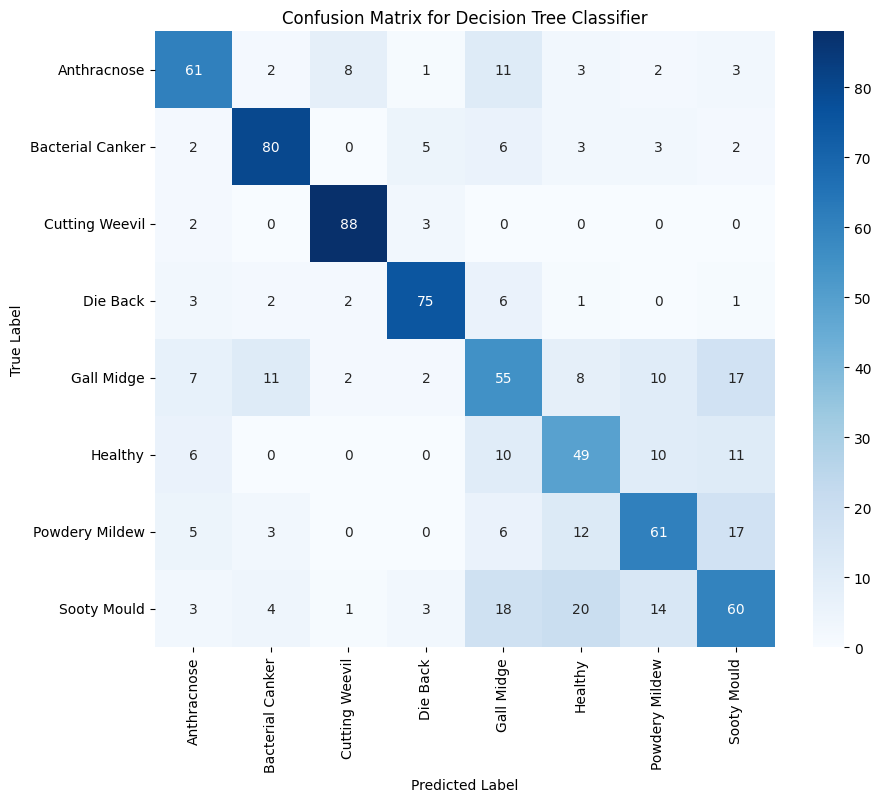

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

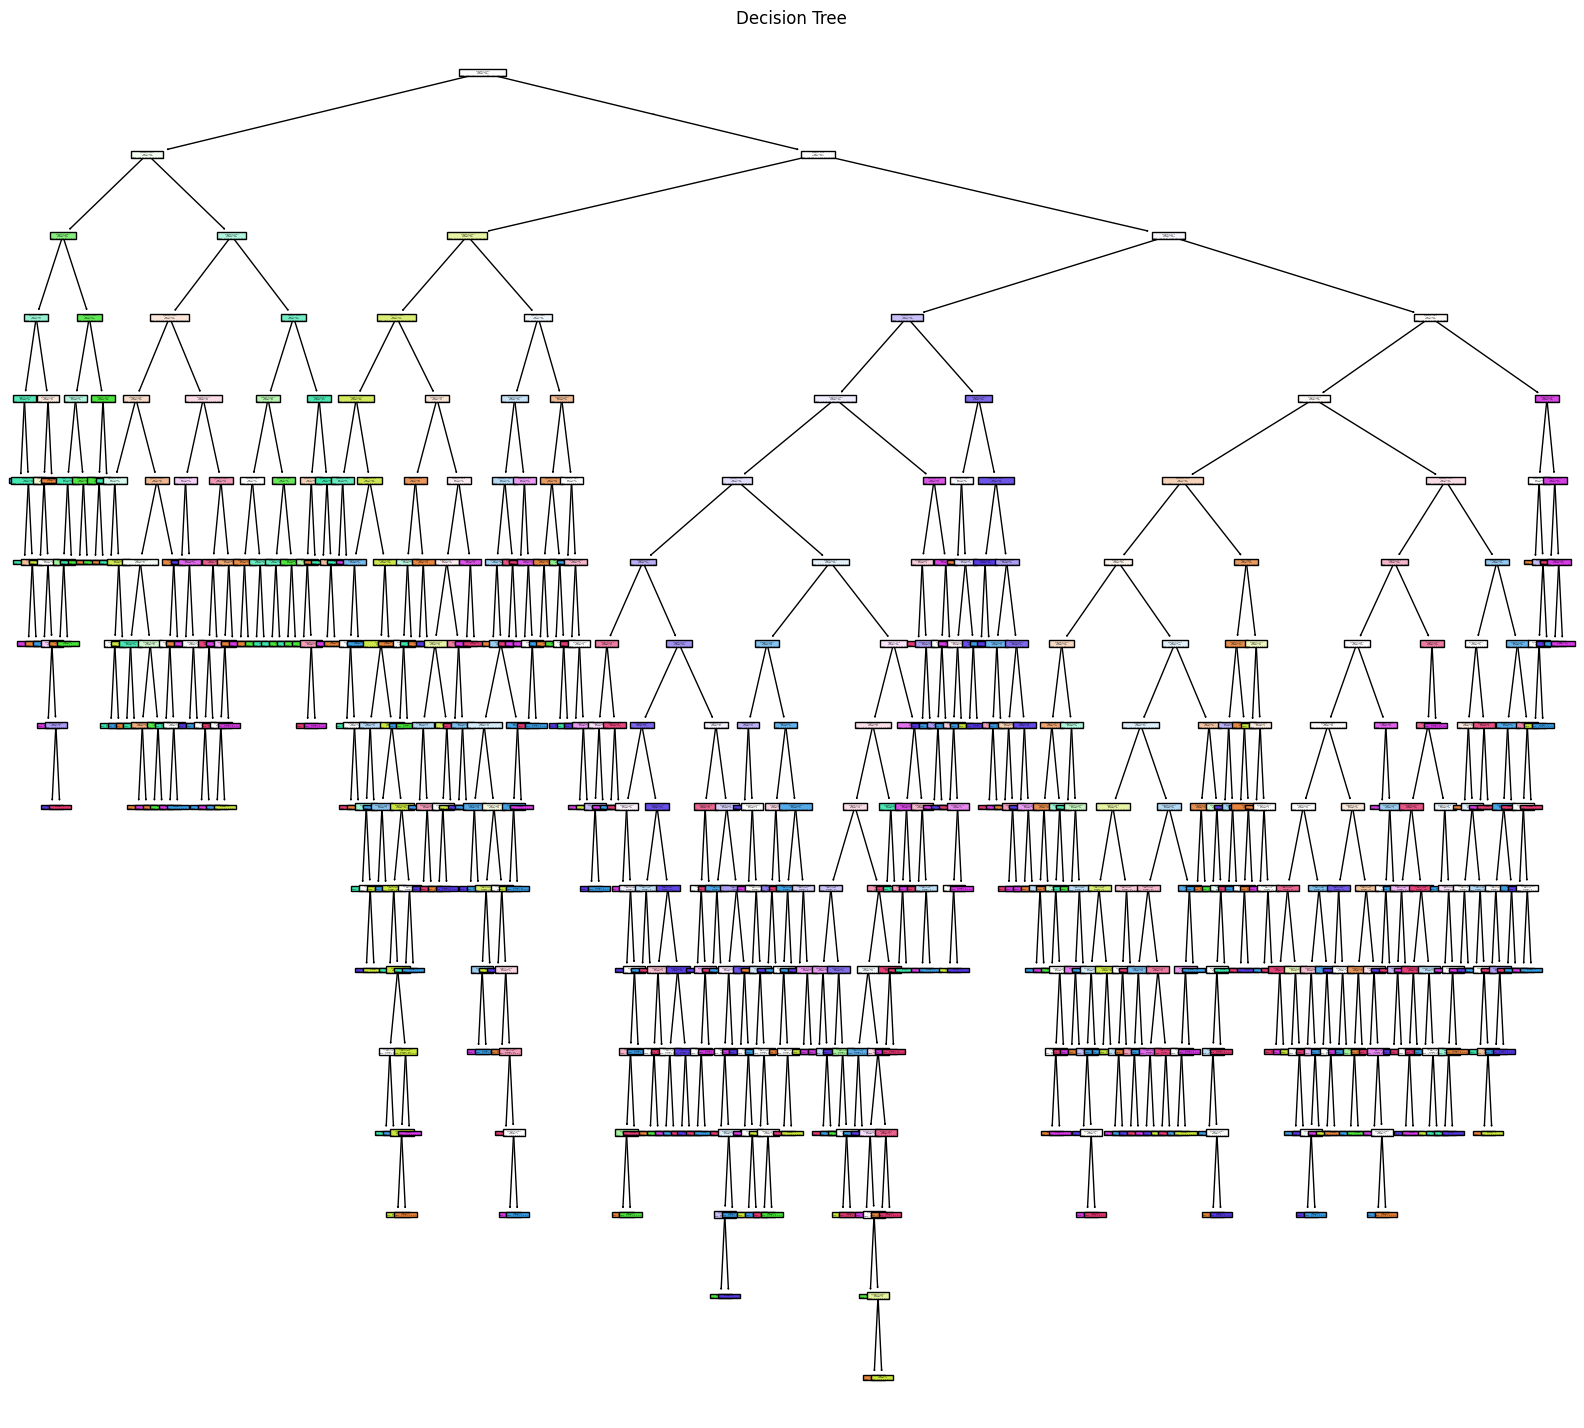

In [ ]:
# plot the decision tree
plt.figure(figsize=(20, 18))

# Use dt_model instead of dt
tree.plot_tree(dt_model, filled=True)

plt.title('Decision Tree')
plt.show()

Decision Tree Accuracy: 0.66125
Random Forest Accuracy: 0.85625


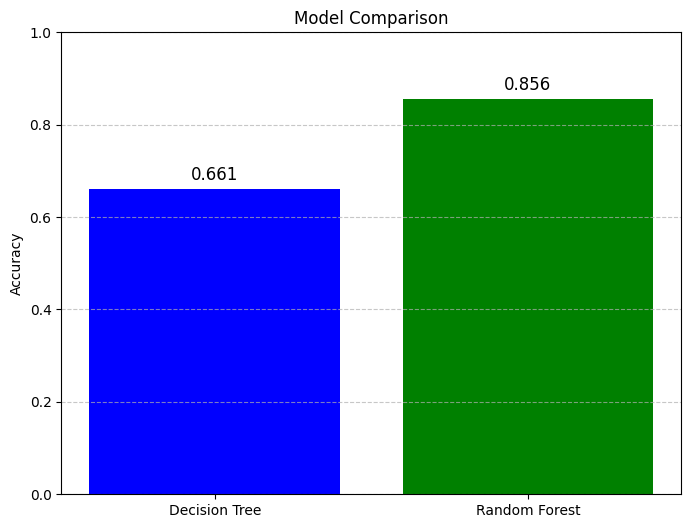

In [ ]:
# Comparison of model performances
# Assign the predictions to specific variables
y_pred_dt = dt_model.predict(X_test)  # Decision Tree predictions
y_pred_rf = rf_model.predict(X_test)  # Random Forest predictions

accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Decision Tree Accuracy:", accuracy_dt)
print("Random Forest Accuracy:", accuracy_rf)

# Plot comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(["Decision Tree", "Random Forest"], [accuracy_dt, accuracy_rf], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()